In [1]:
import numpy as np
from numpy import random as rd
import matplotlib.pyplot as plt

# Linear Models and Optimization

The aim of this notebook is to illustrate different optimization methods for binary classification using linear models. Here, I produce random data according to probability distributions, focused on different locations on the plane. The aim is to build a linear classifier using different gradient descent methods seen this week.

## Data generation

The easiest way is to use a coordinate transformation that transform uniform distributions to more complicated regions on the plane. For sake of simplicity, I will use parabolic coordinates:

$$
x = \sigma \tau \\
y = \frac{1}{2}(\tau^2 - \sigma^2)
$$

To make classification a bit harder, I will generate data with overlapping probability distributions. Not so overlapping that classification is impossible, but enough that classification is not trivial.

### Definition of parameters

Well, I start by defining a set of parameters that bound the regions for the two classes. I explored with scatter plots of the generated data, and found that this values produce boundaries that are highly non linear.

In [58]:
# parameters of boundaries
sigma_low = np.array([-1.9, -1.9])
sigma_top = np.array([1.9, 1.9])
tau_low = np.array([1,1.4])
tau_top = np.array([1.5,1.8])

In [59]:
def GenerateData(num_samples):
    '''
    Function for generating data with
    a parabolic boundary
    '''
    # arrays of data
    examples = np.zeros((num_samples,2))
    targets = np.zeros(num_samples)
    for idx in range(num_samples):
        # compute parameter values according
        # to region and label
        label = rd.choice([0,1])
        sigma = rd.uniform(low=sigma_low[label], high=sigma_top[label])
        tau = rd.uniform(low=tau_low[label], high=tau_top[label])
        # update dataset
        examples[idx,0] = sigma * tau
        examples[idx,1] = 0.5 * (tau**2 - sigma**2)
        targets[idx] = int(label)
    return examples, targets.astype(int)


These are the examples of my training set that would be used  

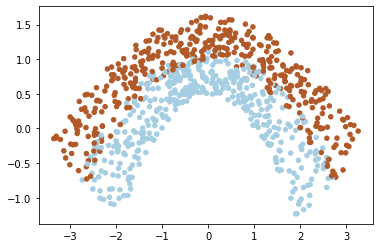

In [60]:
X, y = GenerateData(826)

# Plot dataset
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.Paired, s=20)
plt.show()

## Mapping to a higher dimensional space

This is a sensitive part. A transformation should be devised that allows separation of the dataset using a hyperplane. The symmetry is parabolic, and the parabolas point to the negative $y$ axis. This means that adding quadratic features on $x$, may help solving the classification problem using linear models.

In [68]:
def transform_data(X):
    '''
    Adds parabolic features
    [x1, x2, x1**2]
    '''
    return np.array([[*row, row[0]**2, row[1], np.sqrt(np.abs(row[1]))*row[0], 1] for row in X])

In [70]:
X_expanded = transform_data(X)

## Logistic regression

With this transformation, it is expected that bias is unnecessary, so that the classification score is given only by the inner product $\langle\vec{w}, \vec{x}\rangle$. As a result, we can use the softmax transform to find the probability that an example is classified as a member of class 1

$$
P(y=1 | x, \vec{w}) = \frac{1}{1 + \mathrm{e}^{-\langle\vec{w}, \vec{x}\rangle}} = \sigma(\langle\vec{w}, \vec{x}\rangle)
$$

In the next cell, I define a function that computes this probability.

In [71]:
def probability(X, w):
    '''
    Function for computing the
    probability of y==1 given
    x and w
    '''
    logistic = lambda x: 1 / (1 + np.exp(-1 * sum(xcomp * wcomp for xcomp, wcomp in zip(x,w))))
    return np.array([logistic(example) for example in X])

## Cost function definition

We use as our cost function, the cross-entropy. For a single example, it is defined as

$$
l(x_i, y_1, w) = -y_i \log(P(y_i = 1 | x_i, w)) - (1-y_i) \log(1-P(y_i = 1 | x_i, w))
$$

And for the whole training set

$$
L = \frac{1}{l} \sum_i l(x_1, y_i, w)
$$

In [75]:
def loss(X, y, w):
    '''
    Function for computing loss given w
    '''
    return -1/len(y) * sum(yi * np.log(pi) + (1-yi) * np.log(1 - pi) for yi, pi in zip(y, probability(X, w)))

## Gradient computation

To compute the loss function gradient, let's start by computing the gradient of a single example term. Start by noticing that

$$
\nabla_{\vec{w}} l = \frac{\partial l}{\partial P} \nabla_{\vec{w}} P
$$

So, start by computing the partial derivative of the cross-entropy with respect to the probability distribution

$$
\frac{\partial l}{\partial P} = - \frac{y_i}{P(\vec{w})} + \frac{1-y_i}{1-P(\vec{w})} \\
\frac{\partial l}{\partial P} = \frac{P(\vec{w})-y_i}{P(\vec{w})[1-P(\vec{w})]}
$$

Now we proceed to compute the gradient of the probability distribution with respect to the weight vector

$$
\nabla_{\vec{w}} P = \frac{\mathrm{e}^{-\langle\vec{w}, \vec{x}\rangle}}{(1 + \mathrm{e}^{-\langle\vec{w}, \vec{x}\rangle})^2}(-\vec{x}) = -P(\vec{w})[1 - P(\vec{w})]\vec{x}
$$

From which the gradient is readily computed

$$
\nabla_{\vec{w}}l = [y_i - P(\vec{w})]\vec{x}
$$

As a result, the gradient of the full loss function is simply

$$
\nabla_{\vec{w}} L = \frac{1}{l} \sum_i [y_i - P(y=1 | \vec{x}_i, \vec{w})]\vec{x}_i
$$

In [72]:
def loss_gradient(X, y, w):
    '''
    Function for computing cross
    entropy gradient
    '''
    return 1/len(y) * sum((yi - pi) * xi for xi, yi, pi in zip(X, y, probability(X, w)))

## RMSProps with mini batch stochastic gradient

Now that we know the cost function and its gradient, the rest is performing stochastic gradient descent. The following function performs optimization using mini batch and RMSProps, and returns the optimal values for the weights. The following values for the parameters are used

$$
\eta = 0.1 \\
\alpha = 0.9 \\
\epsilon = 10^{-8}
$$

In [73]:
rd.seed(42)

eta = 0.1
alpha = 0.9
eps = 1e-8

def RMSPropsOptimization(n_iter, batch_size):
    '''
    Function that returns optimal
    weight values for linear
    classification model
    '''
    w = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 1.0])
    loss_data = np.zeros(n_iter)
    g2 = None
    for i in range(n_iter):
        index = rd.choice(X_expanded.shape[0], batch_size)
        loss_data[i] = loss(X_expanded, y, w)
        gt = loss_gradient(X_expanded[index], y[index], w)
        if i == 0:
            g2 = (1 - alpha) * gt ** 2
        g2 = alpha * g2 + (1 - alpha) * gt ** 2
        w = w + eta * np.power(g2 + eps, -1/2) * gt
    return w, loss_data

## Evaluation of the algorithm

Now that all is set up, what is missing is actually executing the optimization, obtain the weights, and compute the predicted target for each example. The following cell does exactly that

Model accuracy: 88.49878934624698


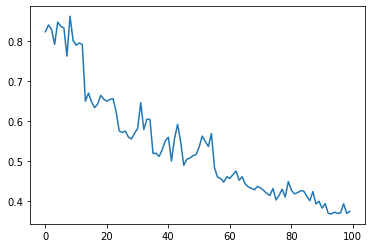

In [84]:
w_optimal, loss_data = RMSPropsOptimization(100, 4)
predicted_probabilities = probability(X_expanded, w_optimal)
y_predicted = np.where(predicted_probabilities > 0.5, 1, 0)
accuracy = 1 - 1/len(y) * sum((y - y_predicted)**2)
print(f"Model accuracy: {accuracy * 100}")
plt.plot(loss_data)
plt.show()

For sake of completeness, I will display the data with the predicted labels instead of the actual labels. Notice that resemblance is uncanny. Actually, the model predicts a pretty good parabolic frontier between the data, and detects that I intentionally overlapped the classes.

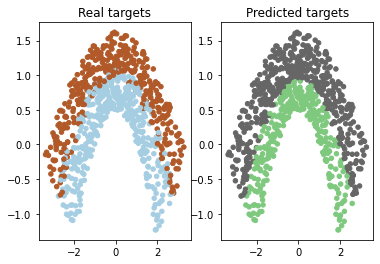

In [90]:
fig, (ax_real, ax_predicted) = plt.subplots(1,2)
ax_real.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.Paired, s=20)
ax_real.set_title('Real targets')
ax_predicted.scatter(X[:,0], X[:,1], c=y_predicted, cmap=plt.cm.Accent, s=20)
ax_predicted.set_title('Predicted targets')
plt.show()